# Bagging Trees and Random Forest Mini Project

This mini project demonstrates the application of my recently acquired knowledge on Bagging Trees and Random Forests.

**Import the required libraries and methods:**

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn import metrics

from tqdm import tqdm
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [34]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}



def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos



def plot_tree(model,filename = "tree.png"):
    #global churn_df

    dot_data = StringIO()


    featureNames = [colunm  for colunm in churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']].columns]
    out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= ['left','stay'], filled=True,  special_characters=True,rotate=False)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(100, 200))
    plt.imshow(img,interpolation='nearest')



def get_accuracy_bag(X,y,title,times=20,xlabel='Number Estimators'):
    #Iterate through different number of estimators and average out the results


    N_estimators=[n for n in range(1,70)]
    times=20
    train_acc=np.zeros((times,len(N_estimators)))
    test_acc=np.zeros((times,len(N_estimators)))

    train_time=np.zeros((times,len(N_estimators)))
    test_time=np.zeros((times,len(N_estimators)))
     #average out the results
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            #Iterate through different number of estimators and average out the results

            Bag= BaggingClassifier(estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 10),n_estimators=n_estimators,bootstrap=True,random_state=0)
            Bag.fit(X_train,y_train)



            Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  Bag)




            train_acc[n,n_estimators-1]=Accuracy['train Accuracy']
            test_acc[n,n_estimators-1]=Accuracy['test Accuracy']



    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(train_acc.mean(axis=0))
    ax2.plot(test_acc.mean(axis=0),c='r')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Training accuracy',color='b')
    ax2.set_ylabel('Testing accuracy', color='r')
    plt.title(title)
    plt.show()


def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})

    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())

    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

**Load the Dataset.**

In this project, I will use the same tumor dataset from my KNN and Decision Trees mini project. The dataset contains lab test results for tumor samples, and the goal is to classify each tumor as malignant (cancerous) or benign.

In [35]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv")

df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [36]:
df = df[df["BareNuc"] != "?"]

In [37]:
X =  df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
y = df['Class']

**Next, I will apply the BaggingClassifier, first tuning its parameters using GridSearchCV(), and then examine the results.**

In [38]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


In [39]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'estimator__max_depth' : [2*n+1 for n in range(10) ] }

In [40]:
Bag = BaggingClassifier(estimator=DecisionTreeClassifier(),
                         random_state=0, bootstrap=True)

search = GridSearchCV(estimator=Bag, param_grid=param_grid, scoring='accuracy', cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'estimator__max_depth': 5, 'n_estimators': 11}
0.9688644688644689


In [ ]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9708029197080292, 'train Accuracy': 0.9853479853479854}


100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


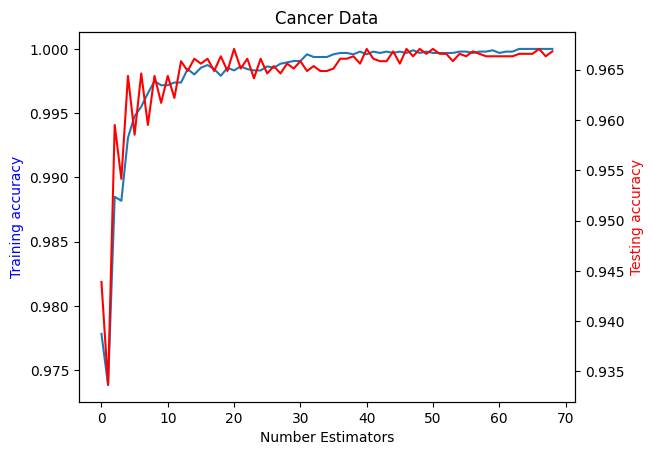

In [ ]:
get_accuracy_bag(X, y, "Cancer Data")

In [41]:
#'estimator__max_depth': 5, 'n_estimators': 11

bag_opt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=11, bootstrap=True, random_state=0)
bag_opt.fit(X_train, y_train)
y_pred = bag_opt.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

[[86  4]
 [ 0 47]]


In [44]:
get_correlation(X_test, y_test, bag_opt).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.8315922810989901


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11
estimator 1,1.000000,0.884952,0.857977,0.872400,0.908190,0.839975,0.857977,0.894170,0.922544,0.935060,0.922544
estimator 2,0.884952,1.000000,0.905744,0.920553,0.891283,0.952799,0.905744,0.909004,0.905744,0.886181,0.905744
estimator 3,0.857977,0.905744,1.000000,0.889411,0.921711,0.889411,0.968506,0.938000,0.937011,0.857427,0.937011
estimator 4,0.872400,0.920553,0.889411,1.000000,0.937491,0.936456,0.889411,0.954035,0.921043,0.904280,0.921043
estimator 5,0.908190,0.891283,0.921711,0.937491,1.000000,0.905988,0.921711,0.984563,0.953076,0.906602,0.984441
estimator 6,0.839975,0.952799,0.889411,0.936456,0.905988,1.000000,0.889411,0.922654,0.889411,0.872201,0.889411
estimator 7,0.857977,0.905744,0.968506,0.889411,0.921711,0.889411,1.000000,0.938000,0.937011,0.857427,0.937011
estimator 8,0.894170,0.909004,0.938000,0.954035,0.984563,0.922654,0.938000,1.000000,0.969244,0.923922,0.969244
estimator 9,0.922544,0.905744,0.937011,0.921043,0.953076,0.889411,0.937011,0.969244,1.000000,0.921302,0.968506
estimator 10,0.935060,0.886181,0.857427,0.904280,0.906602,0.872201,0.857427,0.923922,0.921302,1.000000,0.889364


The model performed exceptionally well, achieving high accuracy and F1 scores, surpassing those from my earlier KNN and Decision Trees mini project.

The correlation heatmap indicates a high average correlation (0.8316). To address this, I will apply Random Forest trees, adding some randomness, and observe the results.

In [49]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'max_depth' : [2*n+1 for n in range(10) ] }

RC = RandomForestClassifier(random_state=0, bootstrap=True)

search = GridSearchCV(estimator=RC, param_grid=param_grid, scoring='accuracy', cv=3)

search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

In [50]:
print(search.best_params_)
print(search.best_score_)

{'max_depth': 3, 'n_estimators': 29}
0.9743589743589745


In [55]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.9708029197080292, 'train Accuracy': 0.9761904761904762}


In [51]:
RF_opt = RandomForestClassifier(max_depth=5, n_estimators=11, random_state=0, bootstrap=True)
RF_opt.fit(X_train, y_train)
y_pred = RF_opt.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

[[86  4]
 [ 0 47]]


In [52]:
get_correlation(X_test, y_test, RF_opt).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.8139201912246169


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11
estimator 1,1.000000,0.731509,0.858982,0.907470,0.906293,0.906293,0.905988,0.937528,0.938474,0.953076,0.876467
estimator 2,0.731509,1.000000,0.809902,0.737546,0.796185,0.763847,0.758708,0.796185,0.801742,0.777430,0.833840
estimator 3,0.858982,0.809902,1.000000,0.892130,0.921711,0.890346,0.889411,0.921711,0.892130,0.905517,0.860999
estimator 4,0.907470,0.737546,0.892130,1.000000,0.907470,0.876467,0.908149,0.938474,0.907682,0.954393,0.876909
estimator 5,0.906293,0.796185,0.921711,0.907470,1.000000,0.937528,0.968993,0.968764,0.938474,0.953076,0.907470
estimator 6,0.906293,0.763847,0.890346,0.876467,0.937528,1.000000,0.905988,0.937528,0.907470,0.921711,0.876467
estimator 7,0.905988,0.758708,0.889411,0.908149,0.968993,0.905988,1.000000,0.968993,0.939417,0.952676,0.908149
estimator 8,0.937528,0.796185,0.921711,0.938474,0.968764,0.937528,0.968993,1.000000,0.969477,0.984441,0.938474
estimator 9,0.938474,0.801742,0.892130,0.907682,0.938474,0.907470,0.939417,0.969477,1.000000,0.954393,0.938455
estimator 10,0.953076,0.777430,0.905517,0.954393,0.953076,0.921711,0.952676,0.984441,0.954393,1.000000,0.923261


In [53]:
def get_accuracy_RF(X,y,title,times=20,xlabel='Number Estimators'):
    #Iterate through different number of estimators and average out the results


    N_estimators=[n for n in range(1,70)]
    times=20
    train_acc=np.zeros((times,len(N_estimators)))
    test_acc=np.zeros((times,len(N_estimators)))

    train_time=np.zeros((times,len(N_estimators)))
    test_time=np.zeros((times,len(N_estimators)))
     #average out the results
    for n in tqdm(range(times)):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
        for n_estimators in N_estimators:
            #Iterate through different number of estimators and average out the results

            #Bag= BaggingClassifier(estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 10),n_estimators=n_estimators,bootstrap=True,random_state=0)
            #Bag.fit(X_train,y_train)

            RF= RandomForestClassifier(max_depth=5, n_estimators=n_estimators, random_state=0, bootstrap=True)
            RF.fit(X_train, y_train)



            Accuracy=get_accuracy(X_train, X_test, y_train, y_test,  RF)




            train_acc[n,n_estimators-1]=Accuracy['train Accuracy']
            test_acc[n,n_estimators-1]=Accuracy['test Accuracy']



    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(train_acc.mean(axis=0))
    ax2.plot(test_acc.mean(axis=0),c='r')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Training accuracy',color='b')
    ax2.set_ylabel('Testing accuracy', color='r')
    plt.title(title)
    plt.show()

100%|██████████| 20/20 [01:36<00:00,  4.85s/it]


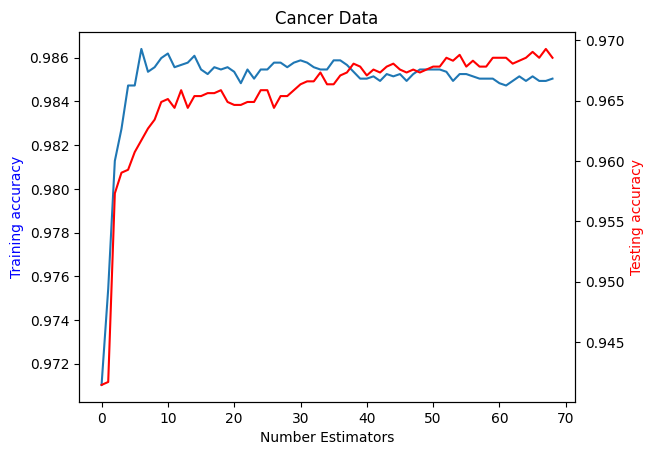

In [54]:
get_accuracy_RF(X, y, "Cancer Data")

The Random Forest trees slightly outperformed Bagging overall, though training accuracy dropped by about 0.01. Introducing some randomness lowered the correlation by approximately 0.02. Increasing randomness in both features and data entries is expected to further enhance model performance and reduce correlation.